# Predicting House Prices Using Multiple Linear Regression 

This project uses multiple linear regression to predict house prices in the city of Ames, Iowa, United States. The data with which this project is based on is available here: https://www.kaggle.com/marcopale/housing?select=AmesHousing.csv

The model is also tested via k-fold cross validation where we find that the optimal number of k-folds for our regression model is 4. 

In [1]:
import pandas as pd
pd.options.display.max_columns = 999
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv("AmesHousing.csv")

In [3]:
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


We begin by defining some functions which will allow us to quickly iterate on different models. The functions will allow us to return a dataframe, select the features we are interested in and then train and test a linear regression model. 

In [4]:
# Transform features function returns the train data frame. 
def transform_features(df):
    return df

# Select features function returns the "Gr Liv Area" and "SalePrice" columns from the train data frame.  
def select_features(df):
    return df[["Gr Liv Area", "SalePrice"]]

# Train and test function selects the first 1460 rows from df and assigns it to train with the remaining rows assigned to test. 
# The function trains a model using all numerical columns except the target column ('SalePrice') from the df returned from select_features()
# The function then tests the model on the test set and returns the root mean squared error (RMSE) value. 

def train_and_test(df):  
    train = df[:1460]
    test = df[1460:]
    
    ## You can use `pd.DataFrame.select_dtypes()` to specify column types
    ## and return only those columns as a data frame.
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include=['integer', 'float'])
    
    ## You can use `pd.Series.drop()` to drop a value.
    features = numeric_train.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    lr.fit(train[features], train["SalePrice"])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test["SalePrice"], predictions)
    rmse = np.sqrt(mse)
    
    return rmse

transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

57088.25161263909

## Data Cleaning and Feature Engineering 

We now remove any features whose number of missing values is beyond our cutoff point, dive deeper into potential categorical features anf transform text and numerical columns. 

Handle missing values:
- All columns:
  - Drop any with 5% or more missing values.
- Text columns:
  - Drop any with 1 or more missing values.
- Numerical columns:
  - For columns with missing values, fill in with the most common value in that column.

1: All columns: Drop any with 5% or more missing values.

In [5]:
## Series object: column name -> number of missing values
num_missing = df.isnull().sum()

In [6]:
# Filter Series to columns containing >5% missing values
drop_missing_cols = num_missing[(num_missing > len(df)/20)].sort_values()

# Drop those columns from the data frame. Note the use of the .index accessor
df = df.drop(drop_missing_cols.index, axis=1)

2: Text columns: Drop any with 1 or more missing values.

In [7]:
# Series object: column name -> number of missing values
text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)

# Filter Series to columns containing *any* missing values
drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]

df = df.drop(drop_missing_cols_2.index, axis=1)

3: Numerical columns: For columns with missing values, fill in with the most common value in that column.

In [8]:
# Compute column-wise missing value counts
num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
fixable_numeric_cols

BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Garage Cars        1
Garage Area        1
Bsmt Full Bath     2
Bsmt Half Bath     2
Mas Vnr Area      23
dtype: int64

In [9]:
# Compute the most common value for each column in `fixable_nmeric_missing_cols`.
replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
replacement_values_dict

{'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Bsmt Unf SF': 0.0,
 'Total Bsmt SF': 0.0,
 'Garage Cars': 2.0,
 'Garage Area': 0.0,
 'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Mas Vnr Area': 0.0}

In [10]:
# Use `pd.DataFrame.fillna()` to replace missing values.
df = df.fillna(replacement_values_dict)

In [11]:
# Verify that every column has 0 missing values
df.isnull().sum().value_counts()

0    64
dtype: int64

We create new features to better capture the information in some of the features.

In [12]:
years_sold = df['Yr Sold'] - df['Year Built']
years_sold[years_sold < 0]

2180   -1
dtype: int64

In [13]:
years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
years_since_remod[years_since_remod < 0]

1702   -1
2180   -2
2181   -1
dtype: int64

In [14]:
# Create new columns
df['Years Before Sale'] = years_sold
df['Years Since Remod'] = years_since_remod

# Drop rows with negative values for both of these new features
df = df.drop([1702, 2180, 2181], axis=0)

# No longer need original year columns
df = df.drop(["Year Built", "Year Remod/Add"], axis = 1)

We now drop columns that are not useful for ML or leak data about the final sale.

PID is a district number and order is the order in which house sales have been listed. Both of these figures are irrelvant for predicting house price and are thus dropped. Month sold, year sold, sale condition and sale type leak info about the date and type of sale and are thus also removed. 

In [15]:
# Drop columns that aren't useful for ML
df = df.drop(["PID", "Order"], axis=1)

# Drop columns that leak info about the final sale
df = df.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)

We incorporate all this data cleaning into the transform_features() function to allow for quick iteration through models. 

In [16]:
df = pd.read_csv("AmesHousing.csv")

In [17]:
def transform_features(df):
    num_missing = df.isnull().sum()
    drop_missing_cols = num_missing[(num_missing > len(df)/20)].sort_values()
    df = df.drop(drop_missing_cols.index, axis=1)
    
    text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]
    df = df.drop(drop_missing_cols_2.index, axis=1)
    
    num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
    fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
    replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
    df = df.fillna(replacement_values_dict)
    
    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod
    df = df.drop([1702, 2180, 2181], axis=0)

    df = df.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type", "Year Built", "Year Remod/Add"], axis=1)
    return df


df = pd.read_csv("AmesHousing.csv")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

55275.367312413066

## Feature Selection

Now that we have cleaned and transformed a lot of the features, we need to select numerical features for our regression model. 

In [18]:
# We select only numerical data columns. 

numerical_df = transform_df.select_dtypes(include=['int', 'float'])
numerical_df.head(5)

,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath,Garage Cars,Garage Area
0,112.0,639.0,0.0,441.0,1080.0,1.0,0.0,2.0,528.0
1,0.0,468.0,144.0,270.0,882.0,0.0,0.0,1.0,730.0
2,108.0,923.0,0.0,406.0,1329.0,0.0,0.0,1.0,312.0
3,0.0,1065.0,0.0,1045.0,2110.0,1.0,0.0,2.0,522.0
4,0.0,791.0,0.0,137.0,928.0,0.0,0.0,2.0,482.0


In [19]:
corr_coefficients = abs(transform_df.corr()['SalePrice']).sort_values(ascending = False)
corr_coefficients[corr_coefficients>0.3]

SalePrice            1.000000
Overall Qual         0.801206
Gr Liv Area          0.717596
Garage Cars          0.648361
Total Bsmt SF        0.644012
Garage Area          0.641425
1st Flr SF           0.635185
Years Before Sale    0.558979
Full Bath            0.546118
Years Since Remod    0.534985
Mas Vnr Area         0.506983
TotRms AbvGrd        0.498574
Fireplaces           0.474831
BsmtFin SF 1         0.439284
Wood Deck SF         0.328183
Open Porch SF        0.316262
Name: SalePrice, dtype: float64

In [20]:
# We keep columns with a correlation coefficient larger than 0.3 (an arbitrary figure, can be changed later).

correlated_cols = corr_coefficients[corr_coefficients>0.3].index
correlated_cols

Index(['SalePrice', 'Overall Qual', 'Gr Liv Area', 'Garage Cars',
       'Total Bsmt SF', 'Garage Area', '1st Flr SF', 'Years Before Sale',
       'Full Bath', 'Years Since Remod', 'Mas Vnr Area', 'TotRms AbvGrd',
       'Fireplaces', 'BsmtFin SF 1', 'Wood Deck SF', 'Open Porch SF'],
      dtype='object')

In [21]:
## Drop columns with less than 0.4 correlation with SalePrice

transform_df[correlated_cols].head(5)

,SalePrice,Overall Qual,Gr Liv Area,Garage Cars,Total Bsmt SF,Garage Area,1st Flr SF,Years Before Sale,Full Bath,Years Since Remod,Mas Vnr Area,TotRms AbvGrd,Fireplaces,BsmtFin SF 1,Wood Deck SF,Open Porch SF
0,215000,6,1656,2.0,1080.0,528.0,1656,50,1,50,112.0,7,2,639.0,210,62
1,105000,5,896,1.0,882.0,730.0,896,49,1,49,0.0,5,0,468.0,140,0
2,172000,6,1329,1.0,1329.0,312.0,1329,52,1,52,108.0,6,0,923.0,393,36
3,244000,7,2110,2.0,2110.0,522.0,2110,42,2,42,0.0,8,2,1065.0,0,0
4,189900,5,1629,2.0,928.0,482.0,928,13,2,12,0.0,6,1,791.0,212,34


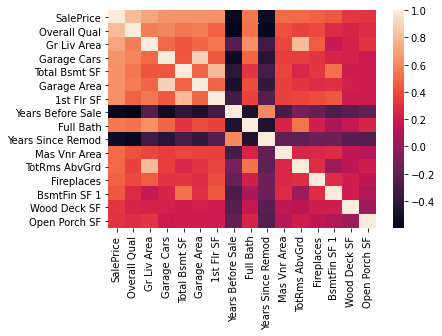

In [22]:
# Plot correlation heatmap to visualize results. 


corrmat = transform_df[correlated_cols].corr()
sns.heatmap(corrmat)

## Categorical Features

The following features are categorical variables. 

In [23]:
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

We also need to find features which are currently numerical but need to be encoded as categorical variables as the numbers they have don't have any semantic meaning. 

However, if some categorical features have hundreds or thousands of unique values (or categories) then we may have to drop these features as otherwise hundreds of columns will have to be added back to the data frame. 

In [24]:
# We filter for categorical variables which we still have after cleaning and filtering our data.

transform_cat_cols = []
for col in nominal_features:
    if col in transform_df.columns:
        transform_cat_cols.append(col)

# How many unique values in each categorical column?
uniqueness_counts = transform_df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()

# We use an aribtrary cutoff of 10 unique values (however this could be higher). 
drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
transform_df = transform_df.drop(drop_nonuniq_cols, axis=1)

In [25]:
## Select just the remaining text columns and convert into categorical features. 
text_cols = transform_df.select_dtypes(include=['object'])
for col in text_cols:
    transform_df[col] = transform_df[col].astype('category')
    
## Create dummy columns and add back to the dataframe!
transform_df = pd.concat([transform_df,pd.get_dummies(transform_df.select_dtypes(include=['category']))], axis=1).drop(text_cols,axis=1)

We can incoporate this cleaning of categorical features into the select_features() function.

In [26]:
def select_features(df, coeff_threshold=0.4, uniq_threshold=10):
    abs_corr_coeffs = abs(transform_df.corr()['SalePrice']).sort_values()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < coeff_threshold].index, axis=1)
    
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)

    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1).drop(text_cols,axis=1)
    
    return df

## Choose the Type of Cross Validation

We add a parameter, k, to control the type of cross validation that occurs to validate the regression model. 

The k paramter accepts integer values with a default value of 0. When k=0, holdout validation is implemented (this splits the data into 2 parts to test and train) which is what is already currently implemented in the train_and_test() function. 

When k=1, simple cross validation is performed. The ordering of rows is shuffled and the first half assigned to fold_one and second half to fold_two. We train on fold_one and test on fold_two, then train on fold_two and test on fold_one and then return an average RMSE value for each validation. 

When k>0, this is also known as k-fold cross-validation where the average RMSE value is returned over all (k-fold) train-test splits. 

We subsequently update the train_and_test() function to incorporate this parameter k which returns the average RMSE value and standard deviation of RMSE values. The other final functions for transform_features() and select_features() are also attached below. 

In [27]:
def transform_features(df):
    num_missing = df.isnull().sum()
    drop_missing_cols = num_missing[(num_missing > len(df)/20)].sort_values()
    df = df.drop(drop_missing_cols.index, axis=1)
    
    text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]
    df = df.drop(drop_missing_cols_2.index, axis=1)
    
    num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
    fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
    replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
    df = df.fillna(replacement_values_dict)
    
    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod
    df = df.drop([1702, 2180, 2181], axis=0)

    df = df.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type", "Year Built", "Year Remod/Add"], axis=1)
    return df

def select_features(df, coeff_threshold=0.4, uniq_threshold=10):
    abs_corr_coeffs = abs(transform_df.corr()['SalePrice']).sort_values()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < coeff_threshold].index, axis=1)
    
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)

    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1).drop(text_cols,axis=1)
    
    return df

def train_and_test(df, k=0):
    numeric_df = df.select_dtypes(include=['integer', 'float'])
    features = numeric_df.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]

        lr.fit(train[features], train["SalePrice"])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test["SalePrice"], predictions)
        rmse = np.sqrt(mse)
        std_rmse = 0

        return rmse,std_rmse
    
    elif k == 1:
        # Randomize *all* rows (frac=1) from `df` and return
        shuffled_df = df.sample(frac=1, )
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train["SalePrice"])
        predictions_one = lr.predict(test[features])        
        
        mse_one = mean_squared_error(test["SalePrice"], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(test[features], test["SalePrice"])
        predictions_two = lr.predict(train[features])        
       
        mse_two = mean_squared_error(train["SalePrice"], predictions_two)
        rmse_two = np.sqrt(mse_two)
        
        avg_rmse = np.mean([rmse_one, rmse_two])
        std_rmse = 0
        
        return avg_rmse,std_rmse
    
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        avg_rmse = np.mean(rmse_values)
        std_rmse = np.std(rmse_values)
        return avg_rmse, std_rmse 


For example, the following average RMSE and standard deviation of RMSEs is obtained with a minimum correlation level of 0.3 and k-value of 4:

In [28]:
df = pd.read_csv("AmesHousing.csv")
transform_df = transform_features(df)
filtered_df = select_features(transform_df, 0.3)
rmse = train_and_test(filtered_df, k=4)

print(rmse[0])

29019.31888760192


## Parameter Optimization

We can test and train models with different k-values to find which generates the optimal results i.e. has the lowest RMSE value. 

In [29]:
rmses = []
stds = []

for k in range(0,12):
    rmse = float(train_and_test(filtered_df, k)[0])
    std = float(train_and_test(filtered_df, k)[1])
    rmses.append(rmse)
    stds.append(std)

print(rmses)
print(stds)

[33295.52198740695, 30264.80627841288, 30174.953453571914, 29231.876352393345, 28777.799530731216, 28903.74548133644, 29163.097565365693, 28436.02859727205, 28692.99863781464, 28465.64728353052, 28298.779499339435, 28689.390265474547]
[0.0, 0.0, 1509.3939694318742, 2791.201898558056, 4031.695481486712, 4473.491414706776, 6607.457785033523, 6141.809485281336, 6226.955664119915, 6212.713548095368, 8033.782618377063, 7860.085131282081]


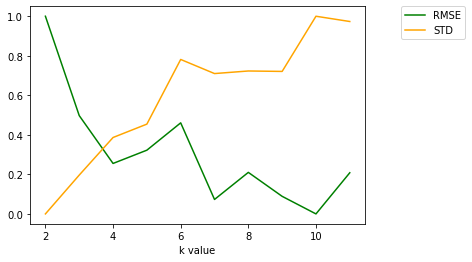

In [30]:
#Get the result of k-fold cross validation
rmses_normalized = []
stds_normalized = []
x = range(2, 12)

#RMSE
for i in rmses[2:]:
    rmses_normalized.append((i - min(rmses[2:]))/(max(rmses[2:]) - min(rmses[2:])))

plt.plot(x,rmses_normalized, label = 'RMSE', color='green')
plt.xlabel('k value')

#STD
for i in stds[2:]:
    stds_normalized.append((i - min(stds[2:]))/(max(stds[2:]) - min(stds[2:])))

plt.plot(x,stds_normalized, label = 'STD', color='orange')
plt.legend(bbox_to_anchor=(1.3,1), borderaxespad=0)

As the graph shows there is a tradeoff between RMSE and STD. A k-value of 4 looks optimal from the graph though. We can verify this by selecting the k-value with the lowest combined standardized scores for average RMSE and STD of RMSE (here we assume we care about RMSE and STD equally). 

In [31]:
# A min-max scaling is used to standardize both average RMSE and std of RMSE values. 

combined = []
for a,b in zip(rmses_normalized, stds_normalized):
    combined.append(a+b)

def optimum(combined_rmse_std_list):
    k_value = 2
    base_value = combined_rmse_std_list[0]
    iteration = 2
    for c in combined_rmse_std_list:
        if c < base_value:
            base_value = c
            k_value = iteration
            iteration = iteration + 1
        else:
            iteration = iteration + 1
    
    return k_value, base_value
        

optimum(combined)

print("The optimal k-value is:", str(optimum(combined)[0]), "which has a combined standardized score of:", str(optimum(combined)[1]))

The optimal k-value is: 4 which has a combined standardized score of: 0.6419133337948719


## Conclusion

This project used feature engineering and selection to create and select features to train a multiple linear regression model. Hold out, simple and k-fold cross validation was used to validate the model. 

When using cross-validation (where k>1) to validate the regression model, the optimal number of folds is 4. 

We can then use our regression model (and optimal number of folds) to predict house sale prices in the city of Ames, Iowa if we know its features. 